In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import os
import numpy as np

In [2]:
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]),
                 'test':transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])}
                                          

In [3]:
data_dir='E:/image_model/Heroine'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','test'] }
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4, shuffle=True) for x in ['train','test']}
dataset_sizes={x: len(image_datasets[x]) for x in ['train','test']}
class_names=image_datasets['train'].classes
print('classname: {}'.format(class_names))
print('there are {} batches in train set'.format(len(dataloaders['train'])))
print(' there arexxx {} batches in test set'.format(len(dataloaders['test'])))
print('there are training {} images'.format(dataset_sizes['train']))
print('there are validation {} images'.format(dataset_sizes['test']))


classname: ['Angelena', 'katrina', 'sunnyleone']
there are 30 batches in train set
 there arexxx 15 batches in test set
there are training 120 images
there are validation 60 images


In [4]:
# load the restnet
model_conv=torchvision.models.resnet18(pretrained=True)


In [5]:
# freez all the layer in network
for param in model_conv.parameters():
    param.required_grads=False
    

In [7]:
model_conv.parameters


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

In [9]:
# gat the input number of the last layer(number of neuron in the last layer)
num_ftrs=model_conv.fc.in_features
# reconstruct the last layer
#model_conv.fc=nn.Linear(num_ftrs,2)
print(num_ftrs)

512


In [10]:
if torch.cuda.is_available():
    model_conv=model_conv.cuda()

In [11]:
criterian=nn.CrossEntropyLoss()
optimizer=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print(exp_lr_scheduler)

In [12]:
num_epochs=100
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    
    # Reset the correct=0 after passing through all the dataset
    correct=0
    for images, labels in dataloaders['train']:
        images=Variable(images)
        labels=Variable(labels)
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        output=model_conv(images)
        loss=criterian(output,labels)
        loss.backward()
        optimizer.step()
        _,predicted=torch.max(output,1)
        correct +=(predicted==labels).sum()
    train_acc= 100 * correct/dataset_sizes['train']
    print('Epoch [{}/{}] , loss: {:.4f}, Train Accuracy {} %'.format(epoch+1, num_epochs,loss.item(), train_acc))
        
        
        
        
        

Epoch [1/100] , loss: 2.0278, Train Accuracy 21 %
Epoch [2/100] , loss: 1.5551, Train Accuracy 43 %
Epoch [3/100] , loss: 0.7132, Train Accuracy 49 %
Epoch [4/100] , loss: 1.7020, Train Accuracy 41 %
Epoch [5/100] , loss: 1.0714, Train Accuracy 49 %
Epoch [6/100] , loss: 1.1768, Train Accuracy 57 %
Epoch [7/100] , loss: 0.7791, Train Accuracy 63 %
Epoch [8/100] , loss: 0.8597, Train Accuracy 61 %
Epoch [9/100] , loss: 0.5069, Train Accuracy 65 %
Epoch [10/100] , loss: 1.4173, Train Accuracy 62 %
Epoch [11/100] , loss: 0.6670, Train Accuracy 69 %
Epoch [12/100] , loss: 0.5102, Train Accuracy 68 %
Epoch [13/100] , loss: 0.4314, Train Accuracy 73 %
Epoch [14/100] , loss: 0.9626, Train Accuracy 65 %
Epoch [15/100] , loss: 0.6775, Train Accuracy 66 %
Epoch [16/100] , loss: 0.3229, Train Accuracy 64 %
Epoch [17/100] , loss: 1.2208, Train Accuracy 64 %
Epoch [18/100] , loss: 0.5907, Train Accuracy 65 %
Epoch [19/100] , loss: 0.6137, Train Accuracy 64 %
Epoch [20/100] , loss: 0.6114, Train Acc

In [14]:
model_conv.eval()
with torch.no_grad():
    correct=0
    total=0
    for images, labels in dataloaders['test']:
        images=Variable(images)
        labels=Variable(labels)
        if torch.cuda.is_available():
            images=images.cuda()
            labels=labels.cuda()
        outputs=model_conv(images)
        _,predicted=torch.max(outputs.data,1)
        total +=labels.size(0)
        correct +=(predicted == labels).sum().item()
    print('accuracy: {:.3f} %'.format(100* correct/total))
        
            
        

accuracy: 61.667 %


In [20]:
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def imshow(inp, title=None):
    """ IMshow for Tensor"""
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.299,0.244,0.255])
    inp= std * inp + mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [23]:
def testImage(image):
    img=imread(image)
    img=imresize(img,(224,224))
    img=img.transpose(2,0,1)
    img=img/255
    img=torch.FloatTensor(img).cuda()
    normalize=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    transform=transforms.Compose([normalize])
    img=transform(img)
    return img

In [24]:
def pred_method(path,class_names):
    
    img=testImage(path)
    testImg=img.unsqueeze(0)
    testImg=testImg.cuda(0)
    output=model_conv(testImg)
    _,predict= torch.max(output, 1)
    img1=img.cpu()
    imshow(img1)
    print(class_names[predict])
    


C:\Users\admin\Anaconda3\envs\pyt\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\admin\Anaconda3\envs\pyt\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


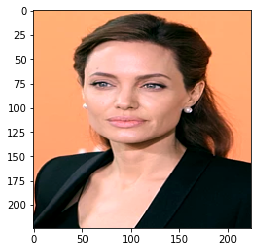

Angelena


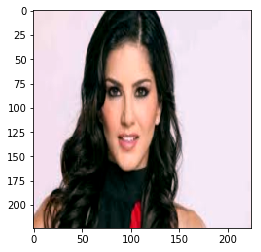

sunnyleone


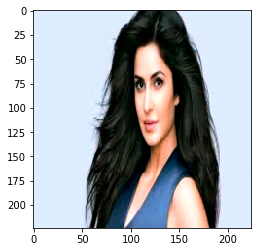

katrina


In [27]:
path='E:testimg/heroinemdl/ang22.jpg'
pred_method(path, class_names)
path1='E:/testimg/heroinemdl/sn22.jpg'
pred_method(path1, class_names) 
path2='E:/testimg/heroinemdl/ktr33.jpg'
pred_method(path2, class_names) 


##### 4 images show